In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [8]:
#Load
df = pd.read_csv("uber.csv")
df = df.drop(columns=['Unnamed: 0','key'], errors='ignore')
df = df.dropna()

In [7]:
# 2. Filter invalid rows
df = df[(df.fare_amount > 0) & (df.passenger_count > 0)]
df = df[df.pickup_latitude.between(-90,90) & df.dropoff_latitude.between(-90,90)]
df = df[df.pickup_longitude.between(-180,180) & df.dropoff_longitude.between(-180,180)]

In [9]:
# 3. Distance (Haversine)
def haversine(lat1, lon1, lat2, lon2):
    p = np.pi/180
    a = (np.sin((lat2-lat1)*p/2)**2 +
         np.cos(lat1*p)*np.cos(lat2*p)*np.sin((lon2-lon1)*p/2)**2)
    return 2*6371*np.arcsin(np.sqrt(a))

df['distance_km'] = haversine(df.pickup_latitude, df.pickup_longitude,
                              df.dropoff_latitude, df.dropoff_longitude)

In [10]:
# 4. Outlier removal using IQR for distance and fare
for c in ['distance_km','fare_amount']:
    Q1 = df[c].quantile(0.25); Q3 = df[c].quantile(0.75); IQR = Q3 - Q1
    low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df = df[(df[c] >= low) & (df[c] <= high)]

In [11]:
# 4. Outlier removal using IQR for distance and fare
for c in ['distance_km','fare_amount']:
    Q1 = df[c].quantile(0.25); Q3 = df[c].quantile(0.75); IQR = Q3 - Q1
    low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df = df[(df[c] >= low) & (df[c] <= high)]

In [12]:
print("Correlation:\n", df[['fare_amount','distance_km','passenger_count']].corr())

Correlation:
                  fare_amount  distance_km  passenger_count
fare_amount         1.000000     0.749431         0.017448
distance_km         0.749431     1.000000         0.003197
passenger_count     0.017448     0.003197         1.000000


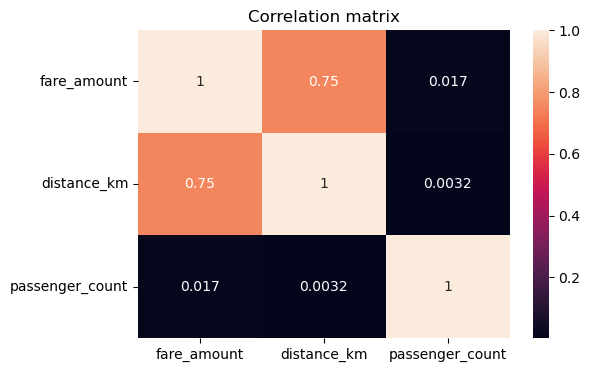

In [13]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['fare_amount','distance_km','passenger_count']].corr(), annot=True)
plt.title("Correlation matrix")
plt.show()

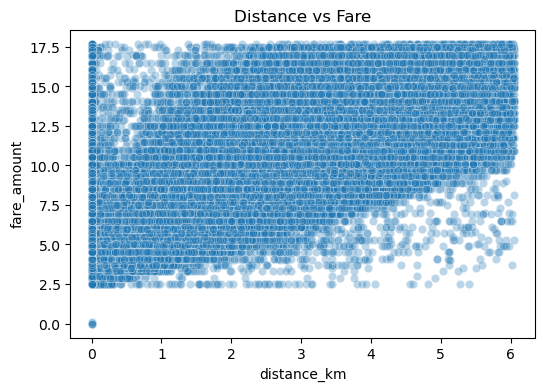

In [14]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='distance_km', y='fare_amount', data=df, alpha=0.3)
plt.title("Distance vs Fare")
plt.show()


In [15]:
# 6. Prepare data and split
X = df[['distance_km','passenger_count']]
y = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)


LinearRegression -> R2: 0.5653, RMSE: 2.1669


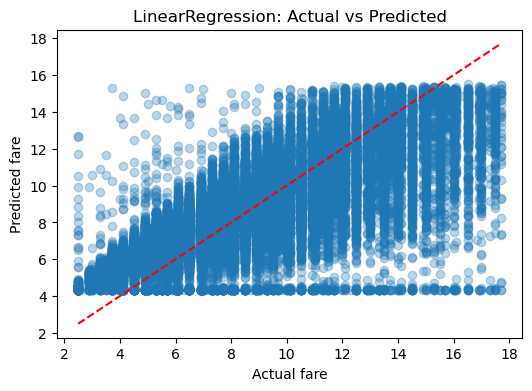


RandomForest -> R2: 0.4751, RMSE: 2.3813


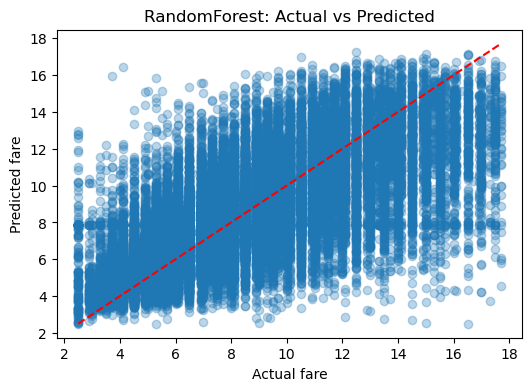

In [16]:
# 7. Models
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, m in models.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = (r2, rmse)
    print(f"\n{name} -> R2: {r2:.4f}, RMSE: {rmse:.4f}")

    # Plot predicted vs actual (first model only or both)
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel("Actual fare")
    plt.ylabel("Predicted fare")
    plt.title(f"{name}: Actual vs Predicted")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.show()

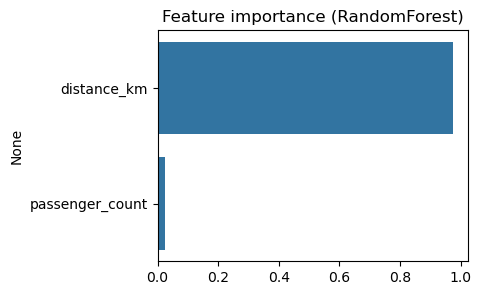

In [18]:
# Feature importance for RandomForest
rf = models['RandomForest']
importances = rf.feature_importances_
plt.figure(figsize=(4,3))
sns.barplot(x=importances, y=X.columns)
plt.title("Feature importance (RandomForest)")
plt.show()